In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import random
import pickle
import torch.optim as optim

import game_utils

In [2]:
# define dataloader hyper params
BATCH_SIZE = 64
SHUFFLE = True   # Set to True if you want to shuffle the data
VAL_SIZE = 6400*2
NUM_EXAMPLES = 64000 + VAL_SIZE
NOISE_GENERATED = True

# train on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running: "+str(device))

Running: cuda


In [4]:
"""
Take in an MxN tensor where N represents the number of columns.
Normalize each column in the indices list based on computing the
max and min values in the column and normalizing to [0,1] linearly
"""
def normalize_tensor(tensor, indices):
    for i in indices:
        col = tensor[:,i]
        col_max = torch.max(col)
        col_min = torch.min(col)
        
        diff = col_max - col_min
        diff = max(diff, 1e-12) # avoids possible div by 0
        
        normalized_col = (col - col_min) / diff
        tensor[:,i] = normalized_col
        print(str(i)+", "+str(col_min)+", "+str(col_max))
        
    return tensor
        
# define helper functions needed to generate a state space
def get_action_number():
    """
    Return 0 with prop .5, 1 with prob .5
    """
    p = random.random()
    if p <= 0.5:
        return 0
    else:
        return 1

def get_banked_score():
    """
    Returns a number 0 to 11000

    If the score is over 10000, resample until a score less than 10000
    is reached with probability 0.5

    """

    n = random.randint(0, 11000)
    p = random.random()

    if n > 10000 and p > .5:
        n = random.randint(0,10000)

    return round(n / 50) * 50


def get_dice_num():
    """
    Generates a number between 1 and 6 (inclusive)

    Can be used to represent the number of dice available to roll or the
    value a dice takes on

    """
    return random.randint(1,6)

def get_accrued_score():
    """
    Generates a value for the accrued score.
    1. Choose a bucket with some probability
    2. Randomly pick a number from that bucket
    """

    p = random.random()

    # pull from [50,1000]
    if p <= .3:
        lo = 0
        hi = 0

    elif p <= .72:
        lo = 50
        hi = 1000

    # pull from [1000,2000]
    elif p <= 0.895:
        lo = 1000
        hi = 2000

    # pull from [2000,5000]
    elif p <= 0.965:
        lo = 2000
        hi = 5000

    # pull from [5000,10000]
    else:
        lo = 5000
        hi = 10000

    return round(random.randint(lo,hi) / 50) * 50

def roll_dice(n):
    """
    Rolls n dice
    """
    possible_values = [1,2,3,4,5,6]

    roll = []
    for i in range(n):
        roll.append(random.choice(possible_values))

    return tuple(sorted(roll))


# write a function to generate a state space vector
def get_state(device):
    action = get_action_number()
    player_score = get_banked_score()
    opp_score = get_banked_score()
    accrued_score = get_accrued_score()
    num_dice = get_dice_num()
    dice = list(np.zeros(6).astype(int))

    # simulate a dice roll if action is to choose dice
    if action == 1:

        # if the number of dice to choose from for an action=1, resample until
        # you get num dice > 1. This is becuase this decision is deterministic
        while num_dice == 1:
            num_dice = get_dice_num()

        # make sure the roll is scoring, a non-scoring roll is deterministic
        roll = roll_dice(num_dice)
        while game_utils.get_highest_choice(game_utils.get_possible_choices(roll)) == 0:
            roll = roll_dice(num_dice)

        for j in range(num_dice):
            dice[j] = get_dice_num()

    state = [player_score, opp_score, accrued_score, num_dice]
    return torch.tensor(state).float().to(device)   
        

In [5]:
# load in expert data, concatenate state and response, label with 1's
#expert_data = pd.read_csv('../simulations/expert_behavior.csv')
expert_data_df = pd.read_csv("expert_behavior_640k.csv")
expert_data_df['label'] = 1

# filter down to only info relevant to decision 1
expert_data_df = expert_data_df[expert_data_df.Action == 0]
expert_data_df = expert_data_df[['PlayerScore', 'OpponentScore', 'AccruedScore',
       'NumDiceAvailable', 'Outcome1', 'label']]
expert_data_df = expert_data_df.rename(columns={'Outcome1': 'Outcome'})

# only keep the desired number of rows
expert_data_df = expert_data_df[:NUM_EXAMPLES]

print(expert_data_df.columns)

# convert df to labelled dataset
inputs = torch.tensor(expert_data_df.drop('label', axis=1).values, dtype=torch.float32).to(device)
labels = torch.tensor(expert_data_df['label'].values, dtype=torch.float32).to(device)

# normalize the inputs
inputs = normalize_tensor(inputs, [0,1,2,3])

# save off validation set
expert_val_inputs = inputs[:VAL_SIZE]
expert_val_labels = labels[:VAL_SIZE]

inputs = inputs[VAL_SIZE:]
labels = labels[VAL_SIZE:]

expert_data = TensorDataset(inputs, labels)
expert_data_loader = DataLoader(expert_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

print("Expert data: "+str(inputs.shape))
print("Expert labels: "+str(labels.shape))
print("Expert val data: "+str(expert_val_inputs.shape))
print("Expert val data: "+str(expert_val_labels.shape))

Index(['PlayerScore', 'OpponentScore', 'AccruedScore', 'NumDiceAvailable',
       'Outcome', 'label'],
      dtype='object')
0, tensor(0., device='cuda:0'), tensor(11000., device='cuda:0')
1, tensor(0., device='cuda:0'), tensor(11000., device='cuda:0')
2, tensor(0., device='cuda:0'), tensor(10000., device='cuda:0')
3, tensor(1., device='cuda:0'), tensor(6., device='cuda:0')
Expert data: torch.Size([64000, 5])
Expert labels: torch.Size([64000])
Expert val data: torch.Size([12800, 5])
Expert val data: torch.Size([12800])


In [6]:
# generate a large matrix of noise and keep it on the device.
# Each time a batch of generated data is needed, it will sample this vector
if not NOISE_GENERATED:
    num_states = len(expert_data_df)

    random_states = []
    for _ in range(num_states):
        state = get_state(device)
        random_states.append(state)

    random_states = torch.stack(random_states, dim=0).to(device)
    labels = torch.zeros(len(expert_data_df)).float().to(device)

    # normalize the states
    random_states = normalize_tensor(random_states,[0,1,2,3])
    
    with open('random_state_tensors.pickle', 'wb') as f:
        pickle.dump(random_states, f)
        pickle.dump(labels,f)
        
if NOISE_GENERATED:
    with open('random_state_tensors.pickle', 'rb') as f:
        random_states = pickle.load(f)
        labels = pickle.load(f)
        
# extract a validation set
random_val_inputs = random_states[:VAL_SIZE]
random_val_labels = labels[:VAL_SIZE]

random_states = random_states[VAL_SIZE:]
labels = labels[VAL_SIZE:]

random_data = TensorDataset(random_states, labels)
random_loader = DataLoader(random_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

print("Random data train: "+str(random_states.shape))
print("Random labels train: "+str(labels.shape))
print("Random data val: "+str(random_val_inputs.shape))
print("Random labels val: "+str(random_val_labels.shape))

Random data train: torch.Size([64000, 4])
Random labels train: torch.Size([64000])
Random data val: torch.Size([12800, 4])
Random labels val: torch.Size([12800])


In [7]:
# function to return a batch of labeled imitator data
# requires starting from some space
def get_imitator_batch(imitator, z, labels, device):
    
    z = z.to(device)
    im_out = imitator.forward(z)
        
    # concatenate z and outputs along 2nd dimension
    inputs = torch.cat((z, im_out), dim=1)
    
    return inputs, labels.to(device)

In [8]:
# define imitator (generator) network
class Imitator(nn.Module):
    def __init__(self, indim, outdim):
        super(Imitator, self).__init__()
        self.fc1 = nn.Linear(indim, 4)
        self.fc2 = nn.Linear(4, 3)
        self.fc3 = nn.Linear(3, outdim)

        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.init_weights()

    def forward(self, x):
        
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        
        # round values to be either 0 or 1
        return torch.round(x)
        
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)



In [9]:
# define discriminator network
# this network outputs the probability that an input vector is from Imitator
class Discriminator(nn.Module):
    def __init__(self, indim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(indim, 5)
        self.fc2 = nn.Linear(5, 1)

        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        
        self.init_weights()
    
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):

        x = self.leaky_relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))

        return x


In [10]:
def checkpoint(imitator, discriminator, im_losses, dscrm_losses, im_val_losses, dscrm_val_losses,epoch,im_optim, dscrm_optim):
    # save model outputs
    torch.save(discriminator.state_dict(), 'dec1_discriminator_'+str(epoch)+'.pth')
    torch.save(imitator.state_dict(),'dec1_imitator_'+str(epoch)+'.pth')
    torch.save(im_optim.state_dict(),'dec1_im_optim_'+str(epoch)+'.pth')
    torch.save(dscrm_optim.state_dict(),'dec1_dscrm_optim_'+str(epoch)+'.pth')
    
    with open('dec1_losses_'+str(epoch)+'.pkl', 'wb') as f:
        pickle.dump((im_losses, dscrm_losses,im_val_losses,dscrm_val_losses), f)

In [11]:
"""
Given a batch of expert data and a batch of imitator data, interleave the 
examples and return two batches
"""
def interleave_data(expert_X, expert_Y, im_X, im_Y):
    batch_size = expert_X.shape[0]
    
    X = torch.cat([expert_X, im_X],dim=0)
    Y = torch.cat([expert_Y, im_Y],dim=0)
    
    perm = torch.randperm(X.size(0))
    X = X[perm]
    Y = Y[perm]
    
    b1_X = X[:batch_size]
    b2_X = X[batch_size:]
    
    b1_Y = Y[:batch_size]
    b2_Y = Y[batch_size:]
    
    
    return b1_X, b1_Y, b2_X, b2_Y

In [ ]:
# set up and run the GAN
torch.autograd.set_detect_anomaly(True)

state_dim = 4
imitator_outdim = 1
discriminator_indim = 5

START_EPOCH = 1401
NUM_EPOCHS = 5000

# determines how often discrminiator is trained vs generator
DISCRIMINATOR_TRAIN_RATIO = 5

# todo: determine number of batches
NUM_BATCHES = int(len(expert_data_df)/BATCH_SIZE/DISCRIMINATOR_TRAIN_RATIO)
print("Num batches/epoch: "+str(NUM_BATCHES))

# define hyperparameters
im_LR = 0.001
dscrm_LR = 0.001


# initialize networks
#imitator = Imitator(state_dim, imitator_outdim).to(device)
#discriminator = Discriminator(discriminator_indim).to(device)

# initialize loss functions, optmiizers
im_optim = optim.Adam(imitator.parameters(), lr=im_LR)
dscrm_optim = optim.Adam(imitator.parameters(), lr=dscrm_LR)

# initialize loss function
loss = nn.BCELoss()

#im_test_losses = []
#dscrm_test_losses = []
#im_val_losses = []
#dscrm_val_losses = []

for epoch in range(START_EPOCH,NUM_EPOCHS+1):
    if epoch % 25 == 0:
        print("running epoch " + str(epoch)+"...")
    discriminator.train()
    imitator.train()
    for batch in range(NUM_BATCHES):
            
        expert_batch_iterator = iter(expert_data_loader)
        random_loader_iterator = iter(random_loader)

        # train the discrminator network
        for _ in range(DISCRIMINATOR_TRAIN_RATIO):
            # pass with expert data
            expert_X, expert_Y = next(expert_batch_iterator)
            expert_X = expert_X.to(device)
            expert_Y = expert_Y.to(device)
            
            rand_batch = next(random_loader_iterator)
            im_X, im_Y = get_imitator_batch(imitator, rand_batch[0], rand_batch[1],device)
            
            b1_X, b1_Y, b2_X, b2_Y = interleave_data(expert_X, expert_Y, im_X, im_Y)
            
            # do first interleaved batch
            discriminator.zero_grad()
            b1_output = discriminator.forward(b1_X).squeeze(dim=1)
            lossD_b1 = loss(b1_output, b1_Y)
            lossD_b1.backward()
            
            # Clip gradients to prevent exploding gradient
            max_norm = 1.0  # Maximum norm value
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm)

            # step
            dscrm_optim.step()
            
            # do second interleaved batch
            discriminator.zero_grad()
            b2_output = discriminator.forward(b2_X.detach()).squeeze(dim=1)
            lossD_b2 = loss(b2_output, b2_Y)
            lossD_b2.backward()
            
             # Clip gradients to prevent exploding gradient
            max_norm = 1.0  # Maximum norm value
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm)

            # step
            dscrm_optim.step()

        # train the imitator network
        # use the last batch of imitation data
        # Tricky part here is that loss uses expert_Y (1 vector) as the labels
        imitator.zero_grad()
        batch = next(random_loader_iterator)
        im_X, im_Y = get_imitator_batch(imitator, batch[0], batch[1] ,device)
        output = discriminator.forward(im_X).squeeze(dim=1)
        expert_Y = torch.ones(BATCH_SIZE).float().to(device)
        lossI = loss(output, expert_Y)
        lossI.backward()
        # Clip gradients to prevent exploding gradient
        max_norm = 1.0  # Maximum norm value
        torch.nn.utils.clip_grad_norm_(imitator.parameters(), max_norm)
        im_optim.step()


    # Save test Losses for plotting later
    im_test_losses.append((lossD_b1.item()+lossD_b2.item())/2)
    dscrm_test_losses.append(lossI.item())
    
    # calculate losses on the validation set
    discriminator.eval()
    imitator.eval()
    
    num_val_batches = len(random_val_inputs) // BATCH_SIZE
    
    im_val_loss = 0
    for b in range(num_val_batches):
        random_X = random_val_inputs[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
        random_Y = random_val_labels[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]

        im_val_X, im_val_Y = get_imitator_batch(imitator, random_X,random_Y,device)
        im_val_out = discriminator.forward(im_val_X.detach()).squeeze(dim=1)
        im_val_Y = torch.ones(BATCH_SIZE).float().to(device)
        im_val_loss += loss(im_val_out, im_val_Y).item()
    im_val_losses.append(im_val_loss/num_val_batches)

    dscrm_val_loss = 0
    for b in range(num_val_batches):
        random_X = random_val_inputs[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
        random_Y = random_val_labels[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]

        im_val_X, im_val_Y = get_imitator_batch(imitator, random_X,random_Y,device)
        fake_out = discriminator.forward(im_val_X.detach()).squeeze(dim=1)
        fake_loss = loss(fake_out, im_Y)

        expert_X = expert_val_inputs[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
        expert_Y = expert_val_labels[b * BATCH_SIZE: (b + 1) * BATCH_SIZE]
        expert_out = discriminator.forward(expert_X.detach()).squeeze(dim=1)
        expert_loss = loss(expert_out, expert_Y)
        dscrm_val_loss += fake_loss
        dscrm_val_loss += expert_loss
    dscrm_val_losses.append(dscrm_val_loss/2/num_val_batches)
    
    
    if epoch % 25 == 0:
        print("Checkpointing after: "+str(epoch)+"...")
        checkpoint(imitator, discriminator, im_test_losses, dscrm_test_losses, im_val_losses,dscrm_val_losses,epoch,im_optim,dscrm_optim)


Num batches/epoch: 240
running epoch 1425...
Checkpointing after: 1425...
running epoch 1450...
Checkpointing after: 1450...
running epoch 1475...
Checkpointing after: 1475...
running epoch 1500...
Checkpointing after: 1500...
running epoch 1525...
Checkpointing after: 1525...
running epoch 1550...
Checkpointing after: 1550...
running epoch 1575...
Checkpointing after: 1575...
running epoch 1600...


In [10]:
# save model outputs
#torch.save(discriminator.state_dict(), 'dec1_discriminator.pth')
#torch.save(imitator.state_dict(),'dec1_imitator.pth')
#with open('dec1_losses.pkl', 'wb') as f:
#    pickle.dump((im_test_losses, dscrm_test_losses,im_val_losses,dscrm_val_losses), f)

In [13]:
# recover model parameters, losses, and chart losses
imitator = Imitator(4, 1)
discriminator = Discriminator(5)
im_optim = optim.Adam(imitator.parameters(), lr=0.001)
dscrm_optim = optim.Adam(imitator.parameters(), lr=0.001)

imitator.load_state_dict(torch.load('dec1_imitator_1400.pth',map_location=torch.device(device)))
discriminator.load_state_dict(torch.load('dec1_discriminator_1400.pth',map_location=torch.device(device)))
im_optim.load_state_dict(torch.load('dec1_im_optim_1400.pth',map_location=torch.device(device)))
dscrm_optim.load_state_dict(torch.load('dec1_dscrm_optim_1400.pth',map_location=torch.device(device)))

imitator.to(device)
discriminator.to(device)

with open('dec1_losses_1400.pkl', 'rb') as f:
    im_test_losses,dscrm_test_losses,im_val_losses,dscrm_val_losses = pickle.load(f)



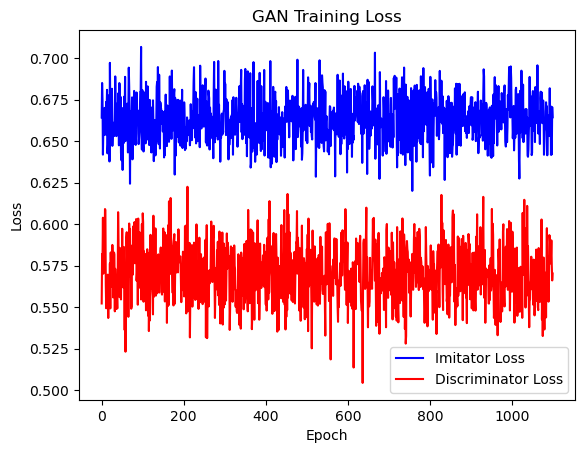

In [14]:
# plot losses
import matplotlib.pyplot as plt

x = range(len(im_test_losses))

plt.plot(x, im_test_losses, label='Imitator Loss', color='blue')
plt.plot(x, dscrm_test_losses, label='Discriminator Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.show()